In [1]:
from matplotlib import pylab as pl
from sim_polarized_source import *
import numpy as np
import sys
sys.path.append('/home/axf295/2019/code/spt3g_software/polcal/python/')
sys.path.append('/home/axf295/2019/code/spt3g_software/build/')
from spt3g import core, std_processing
from Polarization_Fitting import fit_polarization_params as fitp

In [2]:
import CenA_Map_Utils as CMU

T,Q,U = make_sim_CenA_TQU_template_maps()
#TQU_coadds = CMU.load_perband_coaddmaps('/spt/user/production/calibration/CenA-pixelraster/coaddmaps/72096094.g3',xo=-1,yo=-1)


/cvmfs/spt.opensciencegrid.org/py3-v2/RHEL_7_x86_64/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
## TO use IV weighted coadds as template TQU

import pickle as pk
TQU_coadds  = pk.load(open('/big_scratch/axf295/2019/CenA/Analyzed_Data/All/All_Obs_CoaddTQU_IVweightedCoadds.pkl','rb'))
T = {}
Q = {}
U = {}
for band in TQU_coadds:
    T[band] = TQU_coadds[band].maps['T']
    Q[band] = TQU_coadds[band].maps['Q']
    U[band] = TQU_coadds[band].maps['U']

/cvmfs/spt.opensciencegrid.org/py3-v2/RHEL_7_x86_64/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


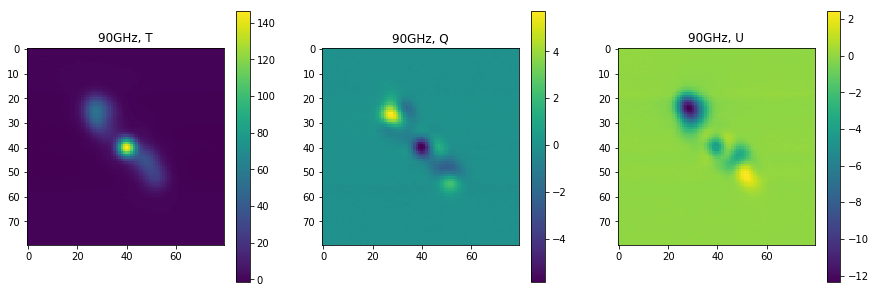

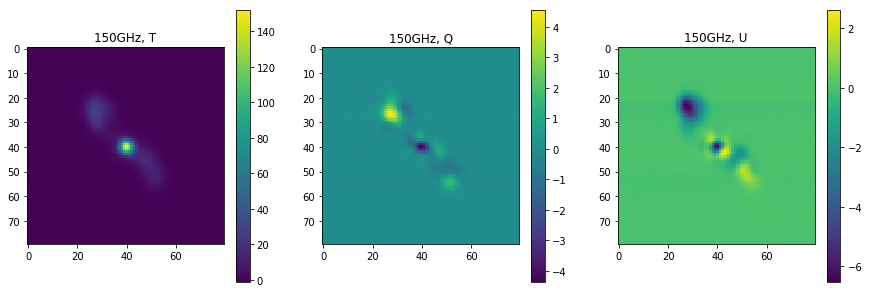

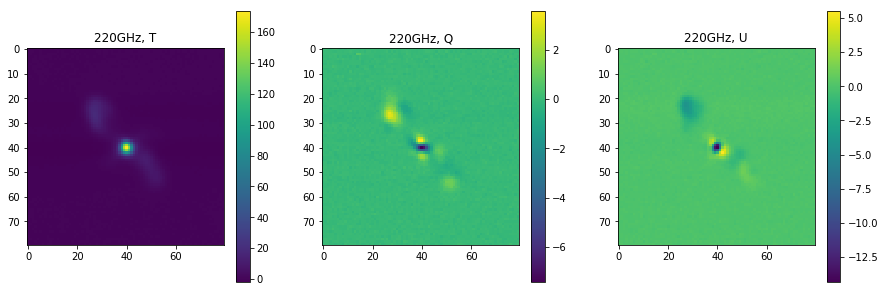

In [4]:
for band in TQU_coadds.keys():
    pl.figure(figsize=(15,5))
    i = 1
    #print(TQU_coadds[band].maps)
    for mt in ['T','Q','U']:
        pl.subplot(1,3,i)
        pl.imshow(TQU_coadds[band].maps[mt]);pl.title('%sGHz, %s'%(band,mt));pl.colorbar()
        i+=1
    pl.show()

In [5]:
T = {}
Q = {}
U = {}
for band in TQU_coadds:
    T[band] = TQU_coadds[band].maps['T']
    Q[band] = TQU_coadds[band].maps['Q']
    U[band] = TQU_coadds[band].maps['U']

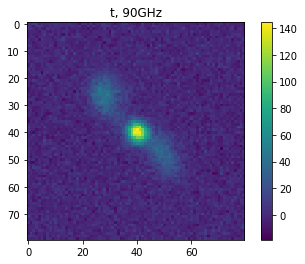

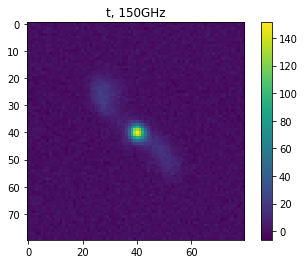

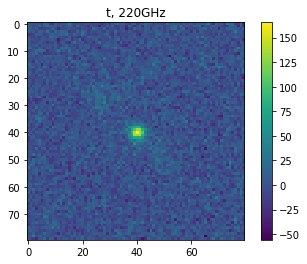

In [6]:
for band in T:
    t  = make_sim_bolo_map(T[band],Q[band],U[band],band,addnoise=True,nomang=61.)
    #t2 = make_sim_bolo_map(T,Q,U,'90',addnoise=True,nomang=45.)
    #t3 = make_sim_bolo_map(T,Q,U,'90',addnoise=True,nomang=90.)

    pl.imshow(t);pl.title('t, %sGHz'%band);pl.colorbar();pl.show()
    #pl.imshow(t2);pl.title('t2');pl.colorbar();pl.show()
    #pl.imshow(T);pl.title('T');pl.colorbar();pl.show()

In [3]:
masknucleus = 1
mask = {}
nucleusR = {'90':8,'150':6,'220':6}
for band in T:
    mask[band] = make_sim_mask_fromT_map(T[band],cutamp=1.)
    masksize = np.shape(mask[band])[0]//2
    if masknucleus:
        for i in np.arange(0,masksize*2,1):
                for j in np.arange(0,masksize*2,1):
                    if np.sqrt((masksize-i)**2+(masksize-j)**2)<nucleusR[band]:
                        mask[band][i][j] *= 0.

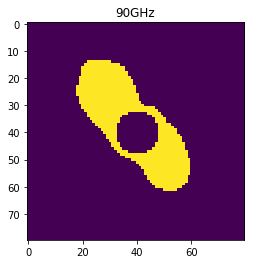

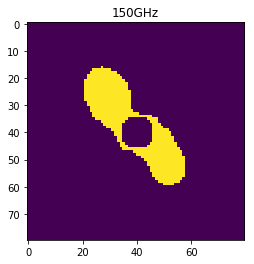

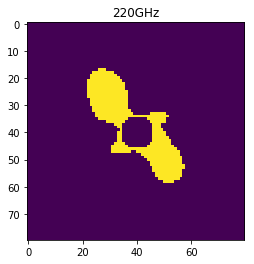

In [8]:
for band in mask:
    pl.imshow(mask[band]);pl.title(band+'GHz');pl.show()


In [10]:
import Circle_Functions as CF
from matplotlib import pylab as plt
savedir = '/home/axf295/2019/tmpPlots/CenA_Sims/'
nomangs = [1.,16.,31.,46.,61.,76.,91.,106.,121.,136.,151.,166.]#
for ang in nomangs:
    print('----------------')
    print(ang)
    for band in ['90','150','220']:
        print(band)
        t  = make_sim_bolo_map(T[band],Q[band],U[band],band,nomang=ang,addnoise=True,numobs=1)
        p = fitp(ang,band,t,T[band],Q[band],U[band],mask[band],VARIABLE='p',plotname=savedir+'%sGHz_%sdeg_nomangsim'%(band,ang))
        print(p)
        p2 = p
        plt.figure(figsize=(35,5))
        plt.subplot(151)
        plt.imshow(t*mask[str(band)])
        plt.title(' %sGHz, %s deg t_i'%(band,ang))
        plt.colorbar()
        plt.grid(color='w',ls='--')
        plt.subplot(152)
        plt.imshow(T[band]*mask[str(band)])
        plt.colorbar()
        plt.grid(color='w',ls='--')
        plt.title('T')
        plt.subplot(153)
        plt.imshow((t-T[band])*mask[str(band)])
        plt.colorbar()
        plt.grid(color='w',ls='--')
        plt.title('t_i-T')
        plt.subplot(154)
        plt.imshow((.5* p2[0][0] * ((2-p2[1][0])*T[band] + p2[1][0] * np.cos(2*np.deg2rad(p2[2][0])) * Q[band] + p2[1][0] * np.sin(2*np.deg2rad(p2[2][0])) * U[band]))*mask[str(band)])
        plt.title("Best Fit t_i")
        plt.colorbar()
        plt.grid(color='w',ls='--')
        plt.subplot(155)
        residuals = ((.5* p2[0][0] * ((2-p2[1][0])*T[band] + p2[1][0] * np.cos(2*np.deg2rad(p2[2][0])) * Q[band] + p2[1][0] * np.sin(2*np.deg2rad(p2[2][0])) * U[band]))-t)*mask[str(band)]
        residuals = residuals[np.nonzero(residuals)]
        var = np.nanvar(t[60:,:20])
        plt.hist(np.ndarray.flatten(residuals)/np.sqrt(var),bins=np.arange(-5,5,.1))
        x = np.arange(-5,5,.01)
        y = 25.*np.exp(-x**2/2.)
        plt.plot(x,y,color='r')
        plt.title("Fit Residual (T-ti)/var(ti)")
        plt.grid(color='w',ls='--')
        plt.savefig(savedir+'%sGHz_%sdeg_nomangsim_FittingPlot.png'%(band,ang))
        plt.close('all')

----------------
1.0
90
[[2.0, 0], [0.98999999999999999, 0], [3.3333333333333286, 0]]
150
[[2.0, 0], [0.98999999999999999, 0], [0.6666666666666643, 0]]
220
[[2.0, 0], [1.0, 0], [-3.0000000000000004, 0]]
----------------
16.0
90
[[2.0, 0], [1.0, 0], [17.0, 0]]
150
[[2.0, 0], [1.01, 0], [16.0, 0]]
220
[[2.0, 0], [1.0800000000000001, 0], [6.6666666666666643, 0]]
----------------
31.0
90
[[2.0, 0], [1.0, 0], [31.0, 0]]
150
[[2.0, 0], [0.97999999999999998, 0], [36.333333333333329, 0]]
220
[[2.0, 0], [0.98999999999999999, 0], [31.0, 0]]
----------------
46.0
90
[[2.0, 0], [1.0, 0], [44.666666666666664, 0]]
150
[[2.0, 0], [1.01, 0], [40.0, 0]]
220
[[2.0, 0], [1.05, 0], [54.0, 0]]
----------------
61.0
90
[[2.0, 0], [1.01, 0], [64.0, 0]]
150
[[2.0, 0], [1.01, 0], [55.0, 0]]
220
[[2.0, 0], [1.0900000000000001, 0], [87.0, 0]]
----------------
76.0
90
[[2.0, 0], [1.01, 0], [77.666666666666657, 0]]
150


KeyboardInterrupt: 

In [8]:
import Circle_Functions as CF

nomangs = [1.,16.,31.,46.,61.,76.,91.,106.,121.,136.,151.,166.]
nomang_fits = {}
nomang_residuals = {}
nomang_sigmas = {}
for ang in nomangs:
    print('----------------')
    print(ang)
    nomang_fits[ang] = {}
    nomang_residuals[ang] = {}
    nomang_sigmas[ang] = {}
    for band in ['90','150','220']:
        print(band)
        nomang_fits[ang][band]      = []
        nomang_residuals[ang][band] = []
        nomang_sigmas[ang][band]    = []
        for i in range(25):
            t  = make_sim_bolo_map(T[band],Q[band],U[band],band,nomang=ang,addnoise=True,randomize_noise=True,numobs=1)
            p = fitp(ang,band,t,T[band],Q[band],U[band],mask[band],VARIABLE='fixed')
            fitang = p[2][0]
            sigma  = p[2][1]
            print(fitang,sigma)
            if fitang<0:
                fitang+=180.
            if fitang>180.:
                fitang-=180.
            #print(fitang)
            
            nomang_fits[ang][band].append(fitang)
            nomang_residuals[ang][band].append(CF.difference(fitang,ang,deg=True))
            nomang_sigmas[ang][band].append(sigma)

----------------
1.0
90
1.33333333333 0
0.0 0
1.0 0
2.66666666667 0
2.0 0
0.666666666667 0
-0.333333333333 0
-0.666666666667 0
0.0 0
2.66666666667 0
0.333333333333 0
-1.0 0
0.0 0
2.66666666667 0
1.33333333333 0
1.33333333333 0
1.0 0
2.0 0
0.0 0
1.0 0
0.333333333333 0
1.0 0
1.0 0
3.0 0
0.0 0
150
0.333333333333 0
-3.33333333333 0
0.666666666667 0
1.66666666667 0
-1.66666666667 0
1.66666666667 0
-1.66666666667 0
0.666666666667 0
4.0 0
2.33333333333 0
2.0 0
-1.33333333333 0
-2.33333333333 0
3.33333333333 0
-1.33333333333 0
3.33333333333 0
6.33333333333 0
2.33333333333 0
0.666666666667 0
0.666666666667 0
5.0 0
3.33333333333 0
1.66666666667 0
-0.333333333333 0
-1.0 0
220
1.66666666667 0
17.6666666667 0
-11.0 0
13.0 0
-3.33333333333 0
-3.0 0
-3.33333333333 0
31.0 0
9.0 0
-29.0 0
17.6666666667 0
25.6666666667 0
-1.66666666667 0
0.666666666667 0
21.3333333333 0
5.0 0
-22.0 0
-10.6666666667 0
-1.0 0
14.0 0
6.66666666667 0
-5.0 0
10.3333333333 0
4.33333333333 0
4.66666666667 0
----------------
16

120.0 0
120.0 0
120.0 0
116.333333333 0
119.0 0
121.333333333 0
121.0 0
123.333333333 0
130.666666667 0
119.666666667 0
124.666666667 0
118.0 0
120.333333333 0
120.0 0
124.0 0
121.333333333 0
123.0 0
119.0 0
118.0 0
117.0 0
121.0 0
121.0 0
123.333333333 0
220
151.0 0
151.0 0
113.333333333 0
108.666666667 0
133.666666667 0
113.0 0
138.0 0
110.666666667 0
151.0 0
132.0 0
135.0 0
148.333333333 0
122.333333333 0
136.666666667 0
122.333333333 0
104.333333333 0
115.666666667 0
132.666666667 0
107.333333333 0
121.666666667 0
127.666666667 0
113.333333333 0
98.0 0
108.333333333 0
119.333333333 0
----------------
136.0
90
137.333333333 0
139.666666667 0
136.0 0
146.0 0
135.666666667 0
136.0 0
135.333333333 0
143.666666667 0
132.333333333 0
137.666666667 0
133.0 0
129.666666667 0
132.333333333 0
141.666666667 0
138.666666667 0
129.666666667 0
132.333333333 0
136.0 0
133.333333333 0
140.0 0
133.333333333 0
141.333333333 0
135.666666667 0
134.333333333 0
139.0 0
150
135.333333333 0
132.0 0
134.333

In [9]:
savedir = './'
import General_Utils as GU
BANDFIG    = {'90':1,'150':2,'220':3}
BANDCOLORS = {'90': 'b','150': 'g','220':'r'}

pl.figure(figsize=(10,10))
offset = {'90':-1,'150':0.,'220':1}
for nomang in sorted(nomang_fits.keys()):
    for band in nomang_fits[nomang]:
        pl.subplot(2,1,1)
        #m = np.average(nomang_fits[nomang][band],weights = 1./np.asarray(nomang_sigmas[nomang][band]))
        #s = CF.std(np.asarray(nomang_fits[nomang][band]),deg=True)
        m = np.mean(nomang_fits[nomang][band])
        s = CF.std(np.asarray(nomang_fits[nomang][band]),deg=True)
        pl.errorbar(nomang+offset[band],m,yerr=s/np.sqrt(len(nomang_fits[nomang][band])), marker='s',color=BANDCOLORS[band])
        pl.subplot(2,1,2)
        #m = np.average(nomang_residuals[nomang][band],weights = 1./np.asarray(nomang_sigmas[nomang][band]))
        #s = CF.std(np.asarray(nomang_residuals[nomang][band]),deg=True)
        m = np.mean(nomang_residuals[nomang][band])
        s = CF.std(np.asarray(nomang_residuals[nomang][band]),deg=True)
        pl.errorbar(nomang+offset[band],m,yerr=s/np.sqrt(len(nomang_fits[nomang][band])),marker='s',color=BANDCOLORS[band])
pl.subplot(211)
pl.plot([0,180],[0,180],color='k',ls='--')
pl.xlabel('Nominal Angle [deg]')
pl.ylabel('Best Fit angle [deg]')
pl.ylim([-20,200])
pl.xlim([-5,180])
pl.grid()
pl.subplot(212)
pl.grid()
#pl.legend()
pl.plot([0,180],[0,0],color='k',ls='--')
pl.ylabel('Residual Angle (deg)')
pl.xlabel('Nominal Angle (deg)')
pl.title('Per-Nomang Pol Angle Residuals; Simulated')
pl.savefig(savedir+'PerNomang_PolAngle_Residual_scatter_Sims.png')
pl.close()  






In [11]:



pl.figure(figsize=(20,20))
angnum = 0
perbandresiduals = {}
for nomang in sorted(bolo_fits.keys()):
    angnum+=1
    pl.subplot(4,4,angnum)
    pl.title('%s deg'%nomang)
    for band in bolo_fits[nomang]:
        if band not in perbandresiduals:
            perbandresiduals[band] = []
        perbandresiduals[band]+= bolo_residuals[nomang][band]
        m,s = GU.calc_median_and_1sigma(bolo_residuals[nomang][band],sigmaclip=3)
       
        pl.hist(bolo_residuals[nomang][band],bins=np.linspace(-90,90,91),
                histtype='step',color=BANDCOLORS[band],label='%s GHz : %.2f +- %.2f'%(band,m,s))
    pl.grid()
    pl.legend()
    pl.xlabel('Residual Angle (deg)')
pl.suptitle('Per-Nomang Pol Angle ResidualsSims')
pl.savefig(savedir+'PerNomang_PolAngle_Residuals_Sims.png')
pl.close()  


pl.figure(figsize=(20,20))
angnum = 0

for nomang in sorted(bolo_fits.keys()):
    angnum+=1
    pl.subplot(4,4,angnum)
    pl.title('%s deg'%nomang)
    for band in bolo_fits[nomang]:
        m,s = GU.calc_median_and_1sigma(bolo_fits[nomang][band],sigmaclip=3)
       
        pl.hist(bolo_fits[nomang][band],bins=np.linspace(-180,180,91),
                histtype='step',color=BANDCOLORS[band],label='%s GHz : %.2f +- %.2f'%(band,m,s))
    pl.grid()
    pl.legend()
    pl.xlabel('Best-Fit Angle (deg)')
pl.suptitle('Per-Nomang Pol Angle Best Fit Sims')
pl.savefig(savedir+'PerNomang_PolAngle_BestFitAngs_Sims.png')
pl.close()  



NameError: name 'bolo_fits' is not defined

In [12]:
pl.figure(figsize=(10,10))
for band in perbandresiduals:
    m,s = GU.calc_median_and_1sigma(perbandresiduals[band],sigmaclip=3)
    pl.hist(perbandresiduals[band],bins=np.linspace(-90,90,91),
            histtype='step',color=BANDCOLORS[band],label='%s GHz : %.2f +- %.2f'%(band,m,s))
pl.suptitle('Per-Band Residuals')
pl.legend()
pl.grid()
pl.savefig(savedir+'PerBand_PolAngle_Residuals_sims.png')
pl.close('all')

/cvmfs/spt.opensciencegrid.org/py3-v2/RHEL_7_x86_64/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/cvmfs/spt.opensciencegrid.org/py3-v2/RHEL_7_x86_64/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [27]:
ang=46.
for band in T:
    t  = make_sim_bolo_map(T[band],Q[band],U[band],band,nomang=ang,addnoise=True,numobs=8)
    p = fitp(band,t,T[band],Q[band],U[band],mask[band],VARIABLE='g',plotname='%sGHz_%sdeg_test'%(band,ang))

TypeError: fit_polarization_params() missing 1 required positional argument: 'mask'

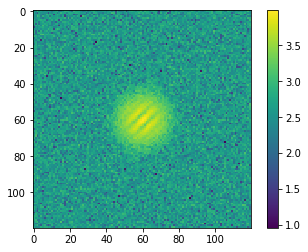

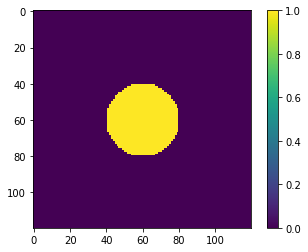

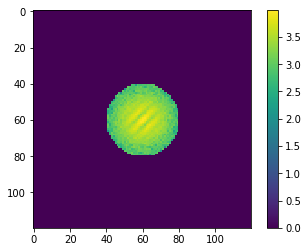

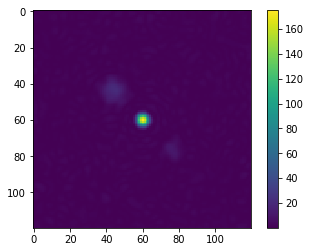

In [87]:
%matplotlib inline

pl.close('all')
fft = np.fft.fft2(t)
pl.imshow(np.log10(abs(np.fft.fftshift(fft))))
pl.colorbar()
pl.show()

pl.figure()
fftmask = np.zeros(np.shape(t))
o = np.shape(t)[0]//2
for i in range(2*o):
    for j in range(2*o):
        if np.sqrt((o-i)**2+(o-j)**2)<20.:
            fftmask[i,j] = 1.
pl.imshow(fftmask)
pl.colorbar()
pl.show()

pl.figure()
pl.imshow(np.log10(abs(np.fft.fftshift(fft)))*fftmask)
pl.colorbar()
pl.show()

t_filt = np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(fft)*fftmask))
pl.figure()
pl.imshow(abs(t_filt))
pl.colorbar()
pl.show()

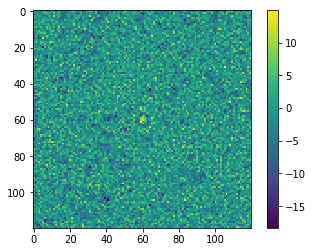

In [89]:

pl.figure()
pl.imshow(t-abs(t_filt))
pl.colorbar()
pl.show()

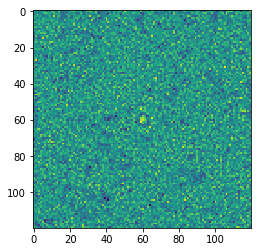

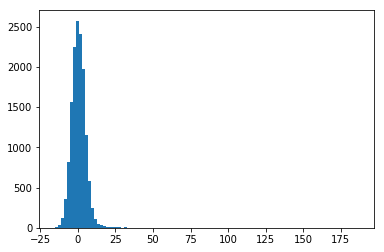

In [91]:
pl.figure()
pl.imshow(t-abs(t_filt))
pl.show()
pl.figure()
pl.hist(np.ndarray.flatten(t-abs(t_filt)),bins=101)
pl.show()

In [86]:
print(band)
p = fitp(band,abs(t_filt),T[band],Q[band],U[band],mask[band],VARIABLE='g',plotname='%sGHz_%sdeg_test'%(band,ang))

220


In [10]:
T1,Q1,U1 = make_sim_TQU_maps('90',polang=45,polfrac=.15,mapsize=120,sigma=1.6,mu=[0.0,0.0],res=.25,ampfactor=1.)
T2,Q2,U2 = make_sim_TQU_maps('90',polang=45,polfrac=.15,mapsize=120,sigma=1.6,mu=[.25,0.0],res=.25,ampfactor=1.)


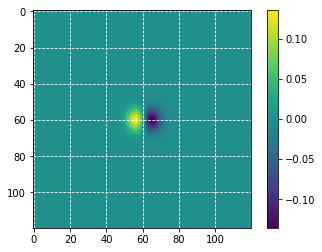

In [11]:
import matplotlib.pylab as plt
max1 = np.amax(T1)
max2 = np.amax(T2)
plt.imshow(T1/max1-T2/max2);plt.colorbar();plt.grid(color='w',ls='--');plt.show()